In [0]:
import os
import cv2 
from PIL import Image
from tqdm.notebook import tqdm
import numpy as np
from IPython.display import clear_output
import matplotlib.pyplot as plt
import shutil
import random 
import pandas as pd

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data.dataset import random_split
from torch.utils.data import Dataset, TensorDataset

plt.rcParams["figure.figsize"] = (35,5)

ROOT = "/content/drive/My Drive/"

In [0]:
## gen sine wave for fun 

In [0]:
np.random.seed(2)

T = 20
L = 1000
N = 100

x = np.empty((N, L), 'int64')
x[:] = np.array(range(L)) + np.random.randint(-4 * T, 4 * T, N).reshape(N, 1)
data = np.sin(x / 1.0 / T).astype('float64')
torch.save(data, open('traindata.pt', 'wb'))

In [0]:
class Sequence(nn.Module):
    def __init__(self):
        super(Sequence, self).__init__()
        self.lstm1 = nn.LSTMCell(1, 51)
        self.lstm2 = nn.LSTMCell(51, 51)
        self.linear = nn.Linear(51, 1)

    def forward(self, input, future = 0):
        outputs = []


        h_t = torch.zeros(input.size(0), 51, dtype=torch.double)
        c_t = torch.zeros(input.size(0), 51, dtype=torch.double)
        h_t2 = torch.zeros(input.size(0), 51, dtype=torch.double)
        c_t2 = torch.zeros(input.size(0), 51, dtype=torch.double)


        for i, input_t in enumerate(input.chunk(input.size(1), dim=1)):
            h_t, c_t = self.lstm1(input_t, (h_t, c_t))
            h_t2, c_t2 = self.lstm2(h_t, (h_t2, c_t2))
            output = self.linear(h_t2)
            outputs += [output]


        for i in range(future):# if we should predict the future
            h_t, c_t = self.lstm1(output, (h_t, c_t))
            h_t2, c_t2 = self.lstm2(h_t, (h_t2, c_t2))
            output = self.linear(h_t2)
            outputs += [output]
        outputs = torch.stack(outputs, 1).squeeze(2)
        return outputs

In [0]:
np.random.seed(0)
torch.manual_seed(0)
# load data and make training set
data = torch.load('traindata.pt')


In [0]:
data.shape ## 100 rows of length 1000  ( height, width )

(100, 1000)

In [0]:
input_x = torch.from_numpy(data[3:, :-1])
target_y = torch.from_numpy(data[3:, 1:])
test_input = torch.from_numpy(data[:3, :-1])
test_target = torch.from_numpy(data[:3, 1:])



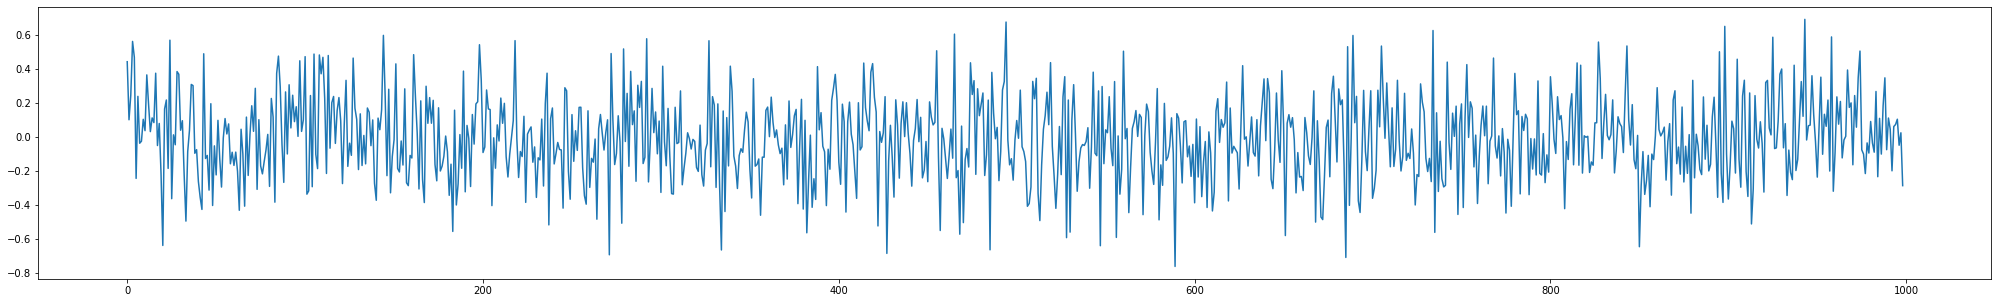

In [25]:
plt.rcParams["figure.figsize"] = (35,5)
noise= torch.Tensor(np.random.randn(97,999)/4).double()
plt.plot(noise[0])
plt.show()

noise_2 = torch.Tensor(np.random.randn(97,999)/4).double()


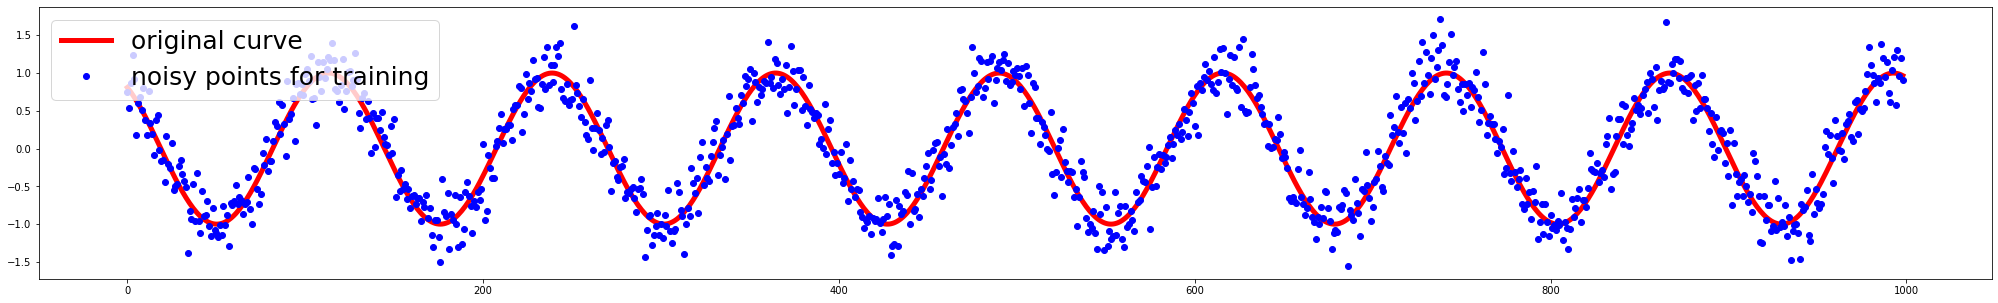

In [26]:
plt.rcParams["figure.figsize"] = (35,5)

plt.plot(input_x[10], "r", label = "original curve", linewidth = 5)

input_x += noise
plt.plot(input_x[10], "bo", label = "noisy points for training")
plt.legend(fontsize = 25)
plt.show()

target_y += noise_2

In [56]:
full_dataset = TensorDataset(input_x, target_y)

train_size = int(0.8 * len(full_dataset))  ## 90/10 split
test_size = len(full_dataset) - train_size
train_dataset, test_dataset = random_split(full_dataset, [train_size, test_size])

train_loader = DataLoader(dataset=train_dataset, batch_size=50, shuffle=True)

val_loader = DataLoader(dataset=test_dataset, batch_size=3, shuffle = True)

print(len(train_loader), "batches ")
print(len(val_loader), " batches ")

2 batches 
7  batches 


In [48]:
inp, target = next(iter(train_loader))

criterion = nn.MSELoss()
output = seq(inp)
print("initial loss = ", criterion(output, target).item())

initial loss =  0.6260938066771113


In [63]:
seq = Sequence()
seq.double()
optimizer = optim.LBFGS(seq.parameters(), lr=0.8)
criterion = nn.MSELoss()
seq

Sequence(
  (lstm1): LSTMCell(1, 51)
  (lstm2): LSTMCell(51, 51)
  (linear): Linear(in_features=51, out_features=1, bias=True)
)

In [0]:



epochs = 2
for epoch in range (epochs):

    for batch in tqdm(train_loader):

        inp, target = batch

        def closure():
            optimizer.zero_grad()
            out = seq(inp)
            loss = criterion(out, target)
            print('loss:', loss.item())
            loss.backward()
            return loss

        optimizer.step(closure)
    clear_output()



loss after one optimizer step =  0.1277


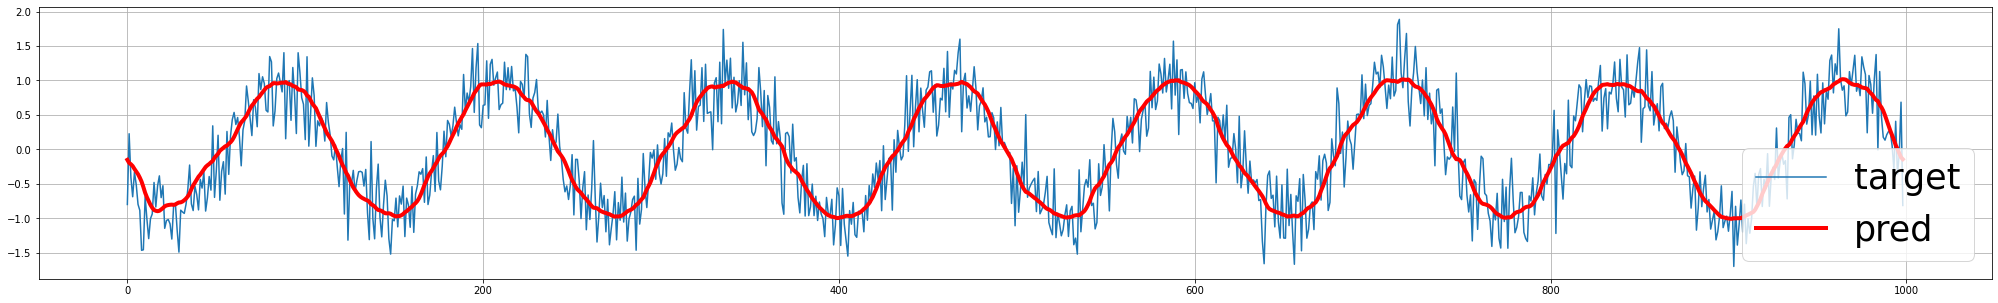

In [66]:
test_sample = next(iter(val_loader))

inp, label = test_sample

output = seq(inp)
print("loss after one optimizer step = ", round(criterion(output, label).item(), 4))
plt.plot(label[0], label = "target")
plt.plot(output[0].detach(), "r", label = "pred", linewidth = 4)
plt.legend(fontsize = 35)
plt.grid()
plt.show()